In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from functions_parameters.tools import rot_symm_m_check_d, translation_check_d, array_print
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_t_4_em4_mesh_30_2_2_pmap_over_filling_seed_121.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
filling_arr = final_result['filling']
filling_mesh, u_mesh = np.meshgrid(filling_arr, u_arr, indexing = 'ij')

Combine the old data points

In [3]:
final_result_111 = np.load('u_v1_v2_t_4_em4_random_basis_mesh_30_2_2_pmap_over_filling.npz')


final_ground_state_e_diff_density_111 = final_result_111['gse']
final_density_111 = final_result_111['d']
final_bond_111 = final_result_111['bond']
final_e_difference_111 = final_result_111['e_diff']
final_c_difference_111 = final_result_111['c_diff']
final_e_fermi_111 = final_result_111['e_fermi']
final_iteration_111 = final_result_111['iters']
any_bi_fail_111 = final_result_111['any_bi_fail']

In [4]:
final_ground_state_e_diff_density = np.concatenate((final_ground_state_e_diff_density, final_ground_state_e_diff_density_111), axis=2)
final_density = np.concatenate((final_density, final_density_111), axis=2)
final_bond = np.concatenate((final_bond, final_bond_111), axis=2)
final_e_difference = np.concatenate((final_e_difference, final_e_difference_111), axis=2)
final_c_difference = np.concatenate((final_c_difference, final_c_difference_111), axis=2)
final_e_fermi = np.concatenate((final_e_fermi, final_e_fermi_111), axis=2)
final_iteration = np.concatenate((final_iteration, final_iteration_111), axis=2)
any_bi_fail = np.concatenate((any_bi_fail, any_bi_fail_111), axis=2)

In [5]:
np.max(final_c_difference)

np.float64(0.004503328794611794)

In [6]:
np.max(final_e_difference)

np.float64(7.742824950784932e-05)

### Some points do not converge that well, but ignore it first

In [7]:
index_c_diff = np.where(np.abs(final_c_difference)>1E-4)
final_ground_state_e_diff_density[index_c_diff] = 0
index_e_diff = np.where(np.abs(final_e_difference)>1E-4)
final_ground_state_e_diff_density[index_e_diff] = 0

In [8]:
index_c_diff

(array([ 4,  5,  5,  5,  5,  5,  5,  6,  7,  7,  7,  8, 11, 11, 13, 19, 19]),
 array([ 9,  8,  8,  8,  8,  8,  8,  4,  4, 13, 15,  2,  5,  8,  8, 15, 15]),
 array([13,  7, 25, 26, 32, 33, 38,  4, 23, 16, 34, 30, 17, 24, 15, 28, 35]))

In [9]:
final_c_difference[index_c_diff]

array([0.00450333, 0.00010736, 0.00024628, 0.00051516, 0.00019119,
       0.00018391, 0.00013063, 0.00062291, 0.00022733, 0.00010955,
       0.00012278, 0.00014084, 0.00015234, 0.00044952, 0.00103983,
       0.00015696, 0.00016537])

### Phase Analysis

In [10]:
translation_a1 = np.kron(np.array([[0,0,1,0],
                           [0,0,0,1],
                           [1,0,0,0],
                           [0,1,0,0]]), np.eye(3))
translation_a2 = np.kron(np.array([[0,1,0,0],
                           [1,0,0,0],
                           [0,0,0,1],
                           [0,0,1,0]]), np.eye(3))
translation_a3 = translation_a1 @ translation_a2
c_6_uc = np.array([[0,0,1],
                   [1,0,0],
                   [0,1,0]])
c_3_uc = c_6_uc@c_6_uc
c_2_uc = c_6_uc @ c_3_uc
c_6_2uc = np.zeros((12, 12))
c_6_2uc[0, 2] = 1
c_6_2uc[1, 6] = 1
c_6_2uc[2, 7] = 1
c_6_2uc[3, 8] = 1
c_6_2uc[4, 0] = 1
c_6_2uc[5, 1] = 1
c_6_2uc[6, -1] = 1
c_6_2uc[7, 3] = 1
c_6_2uc[8, 4] = 1
c_6_2uc[9, 5] = 1
c_6_2uc[10, -3] = 1
c_6_2uc[11, -2] = 1

c_6_2uc = np.moveaxis(np.reshape(c_6_2uc, (2, 2, 3, 2, 2, 3)), (0, 3), (1, 4)).reshape(12, 12)
c_3_2uc = c_6_2uc @ c_6_2uc
c_2_2uc = c_3_2uc @ c_6_2uc

In [11]:
# try define a translated rotation symmetry check operator such that we can check if the phase is genuine stripe orders.
c_6_2uc_gamma = np.zeros((12, 12))
c_6_2uc_gamma[1, 0] = 1
c_6_2uc_gamma[2, 1] = 1
c_6_2uc_gamma[6, 2] = 1
c_6_2uc_gamma[7, 3] = 1
c_6_2uc_gamma[8, 4] = 1
c_6_2uc_gamma[0, 5] = 1
c_6_2uc_gamma[10, 6] = 1
c_6_2uc_gamma[11, 7] = 1
c_6_2uc_gamma[3, 8] = 1
c_6_2uc_gamma[4, 9] = 1
c_6_2uc_gamma[5, 10] = 1
c_6_2uc_gamma[9, 11] = 1

In [12]:
c_6_2uc_y=np.zeros((12, 12))
c_6_2uc_y[10, 0] = 1
c_6_2uc_y[11, 1] = 1
c_6_2uc_y[3, 2] = 1
c_6_2uc_y[4, 3] = 1
c_6_2uc_y[5, 4] = 1
c_6_2uc_y[9, 5] = 1
c_6_2uc_y[1, 6] = 1
c_6_2uc_y[2, 7] = 1
c_6_2uc_y[6, 8] = 1
c_6_2uc_y[7, 9] = 1
c_6_2uc_y[8, 10] = 1
c_6_2uc_y[0, 11] = 1

In [13]:
c_6_2uc_x=np.zeros((12, 12))
c_6_2uc_x[4, 0] = 1
c_6_2uc_x[5, 1] = 1
c_6_2uc_x[9, 2] = 1
c_6_2uc_x[10, 3] = 1
c_6_2uc_x[11, 4] = 1
c_6_2uc_x[3, 5] = 1
c_6_2uc_x[7, 6] = 1
c_6_2uc_x[8, 7] = 1
c_6_2uc_x[0, 8] = 1
c_6_2uc_x[1, 9] = 1
c_6_2uc_x[2, 10] = 1
c_6_2uc_x[6, 11] = 1

In [14]:
c_3_2uc_gamma = c_6_2uc_gamma @ c_6_2uc_gamma
c_2_2uc_gamma = c_3_2uc_gamma @ c_6_2uc_gamma
c_3_2uc_x = c_6_2uc_x @ c_6_2uc_x
c_2_2uc_x = c_3_2uc_x @ c_6_2uc_x
c_3_2uc_y = c_6_2uc_y @ c_6_2uc_y
c_2_2uc_y = c_3_2uc_y @ c_6_2uc_y

In [15]:
ts_phase = ['', 'stripe', '2*2']
nematic_phase = [' R symmetric', ' C3 charge nematic', ' C2 charge nematic', ' no R']
# Magnetism_phase = [' +', ' FM', ' Ferri', ' AFM']
Magnetism_phase = [' +', ' -']

phase_list_final = list(i+j+m for i,j,m in product(ts_phase, nematic_phase, Magnetism_phase))

In [16]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)

In [17]:
phase_diagram_based_on_d = np.zeros((filling_mesh.shape))

threshold = 1E-2
for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        d_ij = sorted_density[i,j,0]
        ts_recording = np.zeros((3))
        rs_recording = np.zeros((4))
        m_recording = np.zeros((2))
        ts_diff_arr = translation_check_d(d_ij, translation_a1, translation_a2, translation_a3)
        if np.all(ts_diff_arr<threshold):
            ts_recording[0] = 1
        elif np.all(ts_diff_arr>threshold):
            ts_recording[-1] = 1
        else:
            ts_recording[1] = 1
        # if ts_recording[0]>0.5:
        #     d_ij = d_ij[:,:3]
        #     c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_ij, c_6_uc, c_3_uc, c_2_uc)
        # else:
        c6_diff_o, c3_diff_o, c2_diff_o, magnetism_arr = rot_symm_m_check_d(d_ij, c_6_2uc, c_3_2uc, c_2_2uc)
        c6_diff_x, c3_diff_x, c2_diff_x, _ = rot_symm_m_check_d(d_ij, c_6_2uc_x, c_3_2uc_x, c_2_2uc_x)
        c6_diff_y, c3_diff_y, c2_diff_y, _ = rot_symm_m_check_d(d_ij, c_6_2uc_y, c_3_2uc_y, c_2_2uc_y)    
        c6_diff_gamma, c3_diff_gamma, c2_diff_gamma, _ = rot_symm_m_check_d(d_ij, c_6_2uc_gamma, c_3_2uc_gamma, c_2_2uc_gamma)
        c6_diff = np.min(np.abs(np.array([c6_diff_o, c6_diff_x, c6_diff_y, c6_diff_gamma])))
        c3_diff = np.min(np.abs(np.array([c3_diff_o, c3_diff_x, c3_diff_y, c3_diff_gamma])))
        c2_diff = np.min(np.abs(np.array([c2_diff_o, c2_diff_x, c2_diff_y, c2_diff_gamma])))
        if c6_diff<threshold:
            rs_recording[0] = 1
        elif c6_diff>threshold and c3_diff<threshold:
            rs_recording[1] = 1
        elif c2_diff<threshold and c6_diff>threshold:
            rs_recording[2] = 1
        else:
            rs_recording[3] = 1
        if np.max(np.abs(magnetism_arr)) > threshold:
            # if np.all(np.sign(np.real(magnetism_arr)) == 1) or np.all(np.sign(np.real(magnetism_arr)) == -1):
            #     m_recording[1] = 1
            # else:
            #     net_m = np.sum(np.real(magnetism_arr))
            #     if np.abs(net_m) <= threshold:
            #         m_recording[3] = 1
            #     else:
            #         m_recording[2] = 1
            m_recording[1] = 1
        else:
            m_recording[0] = 1
        phase_arr = np.kron(ts_recording,rs_recording)
        phase_arr = np.kron(phase_arr,m_recording)
        phase = np.where(phase_arr>0.5)[0][0]
        
        phase_diagram_based_on_d[i,j]=phase

Text(0.5, 1.0, 'filling = 1')

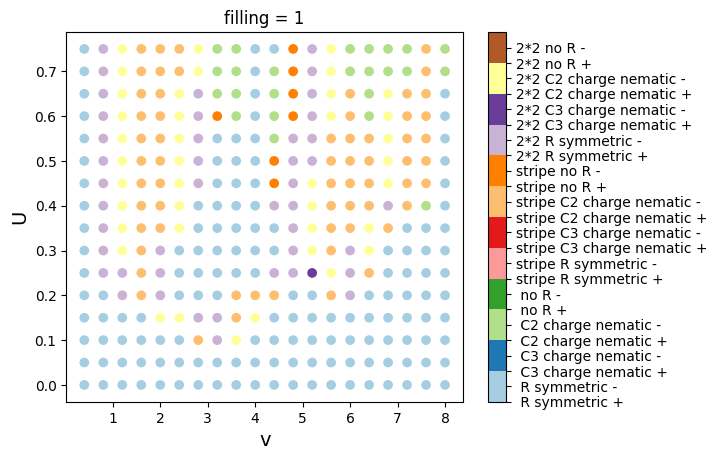

In [18]:
colorbar_ticks_combined = np.arange(len(phase_list_final))
cmap = plt.get_cmap("Paired", len(phase_list_final))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(filling_mesh, u_mesh, c=phase_diagram_based_on_d, cmap=cmap,vmin=0, vmax=len(phase_list_final))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('v', size = '14')
plt.ylabel('U', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(phase_list_final))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(phase_list_final)
plt.title('filling = 1')

In [19]:
unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_list_final[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

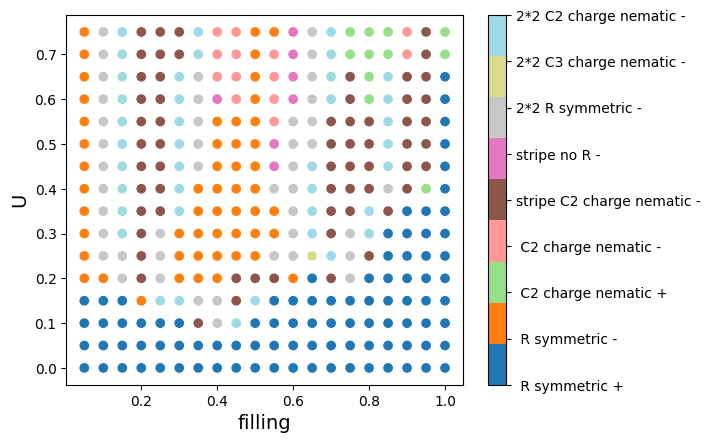

In [20]:
cmap = plt.get_cmap("tab20", len(unique_phase_index))
plt.scatter(filling_mesh/8, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)

In [21]:
filtered_phase_diagram[10,9]

np.float64(5.0)

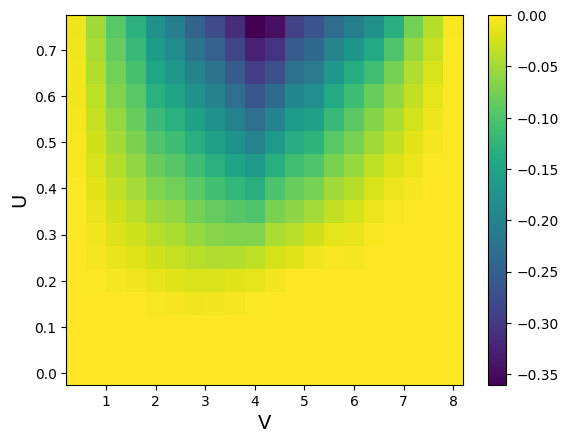

In [22]:
plt.pcolormesh(filling_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

In [23]:
np.mean(final_iteration)

np.float64(77.01386217948718)

# check if any of the points on the phase diagram in under convergence

In [24]:
index=np.where(np.logical_or(sorted_e_difference[:,:,0]>1E-8, sorted_c_difference[:,:,0]>1E-7))
for i in range(len(index[0])):
    print(index[0][i],index[1][i],sorted_c_difference[index[0][i],index[1][i],0], sorted_e_difference[index[0][i],index[1][i],0])

5 11 1.3790005898295377e-07 2.955768962920047e-11
6 12 9.861869854882466e-06 4.483921012266023e-09
16 11 1.374939528064889e-07 1.4011893867404979e-09
17 10 3.021289053939391e-07 1.1430856261540612e-11
19 14 1.5667050485002054e-05 5.881790166029077e-09
19 15 3.589926584531952e-05 1.8821400082913442e-07


### Check the degeneracy

In [25]:
# first find if there are energy states that are highly degenerate as the known ground state while in the different phase
states_index = np.where(np.logical_and(sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]<1E-4, sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]>1E-7))
# then find out the states that are in a different phase than the known ground state
states_index_len = len(states_index[0])
degenerate_state_diagram = -np.ones(final_c_difference.shape, dtype=np.int32)
for index in range(states_index_len):
    i = states_index[0][index]
    j = states_index[1][index]
    k = states_index[2][index]
    print(i,j,k)
    d_ij = sorted_density[i,j,k]
    ts_recording = np.zeros((3))
    rs_recording = np.zeros((4))
    m_recording = np.zeros((2))
    ts_diff_arr = translation_check_d(d_ij, translation_a1, translation_a2, translation_a3)
    if np.all(ts_diff_arr<threshold):
        ts_recording[0] = 1
    elif np.all(ts_diff_arr>threshold):
        ts_recording[-1] = 1
    else:
        ts_recording[1] = 1
    # if ts_recording[0]<1.5:
    #     d_ij = d_ij[:,:3]
    #     c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_ij, c_6_uc, c_3_uc, c_2_uc)
    # else:
    c6_diff_o, c3_diff_o, c2_diff_o, magnetism_arr = rot_symm_m_check_d(d_ij, c_6_2uc, c_3_2uc, c_2_2uc)
    c6_diff_x, c3_diff_x, c2_diff_x, _ = rot_symm_m_check_d(d_ij, c_6_2uc_x, c_3_2uc_x, c_2_2uc_x)
    c6_diff_y, c3_diff_y, c2_diff_y, _ = rot_symm_m_check_d(d_ij, c_6_2uc_y, c_3_2uc_y, c_2_2uc_y)    
    c6_diff_gamma, c3_diff_gamma, c2_diff_gamma, _ = rot_symm_m_check_d(d_ij, c_6_2uc_gamma, c_3_2uc_gamma, c_2_2uc_gamma)
    c6_diff = np.min(np.abs(np.array([c6_diff_o, c6_diff_x, c6_diff_y, c6_diff_gamma])))
    c3_diff = np.min(np.abs(np.array([c3_diff_o, c3_diff_x, c3_diff_y, c3_diff_gamma])))
    c2_diff = np.min(np.abs(np.array([c2_diff_o, c2_diff_x, c2_diff_y, c2_diff_gamma])))
    if c6_diff<threshold:
        rs_recording[0] = 1
    elif c6_diff>threshold and c3_diff<threshold:
        rs_recording[1] = 1
    elif c2_diff<threshold and c6_diff>threshold:
        rs_recording[2] = 1
    else:
        rs_recording[3] = 1
    if np.max(np.abs(magnetism_arr)) > threshold:
        # if np.all(np.sign(np.real(magnetism_arr)) == 1) or np.all(np.sign(np.real(magnetism_arr)) == -1):
        #     m_recording[1] = 1
        # else:
        #     net_m = np.sum(np.real(magnetism_arr))
        #     if np.abs(net_m) <= threshold:
        #         m_recording[3] = 1
        #     else:
        #         m_recording[2] = 1
        m_recording[1] = 1
    else:
        m_recording[0] = 1
    phase_arr = np.kron(ts_recording,rs_recording)
    phase_arr = np.kron(phase_arr,m_recording)
    phase = np.where(phase_arr>0.5)[0][0]
    print(phase_list_final[phase])
    if phase != phase_diagram_based_on_d[i,j] and phase not in degenerate_state_diagram[i,j]:
        degenerate_state_diagram[i,j,k]=phase

0 3 36
 R symmetric +
0 3 37
 R symmetric +
0 3 38
 R symmetric +
1 3 23
 R symmetric +
1 3 24
 R symmetric +
1 3 25
 R symmetric +
1 3 26
 R symmetric +
1 3 27
 R symmetric +
1 3 28
 R symmetric +
1 3 29
 R symmetric +
1 3 30
 R symmetric +
1 3 31
 R symmetric +
1 3 32
 R symmetric +
1 3 33
 R symmetric +
1 3 34
 R symmetric +
1 3 35
 R symmetric +
1 3 36
 R symmetric +
1 3 37
 R symmetric +
1 3 38
 R symmetric +
2 3 23
 R symmetric +
2 3 24
 R symmetric +
2 3 25
 R symmetric +
2 3 26
 R symmetric +
2 3 27
 R symmetric +
2 3 28
 R symmetric +
2 3 29
 R symmetric +
2 3 30
 R symmetric +
2 3 31
 R symmetric +
2 3 32
 R symmetric +
2 3 33
 R symmetric +
2 3 34
 R symmetric +
2 3 35
 R symmetric +
2 3 36
 R symmetric +
2 3 37
 R symmetric +
2 3 38
 R symmetric +
2 6 5
2*2 R symmetric -
2 6 6
2*2 R symmetric -
2 6 7
2*2 R symmetric -
2 6 8
2*2 R symmetric -
2 6 9
2*2 R symmetric -
2 6 10
2*2 R symmetric -
2 6 11
2*2 R symmetric -
2 6 12
2*2 R symmetric -
2 6 13
2*2 R symmetric -
2 6 14
2*2

In [26]:
degenerate_index = np.where(degenerate_state_diagram>0)
degenerate_index

(array([ 2,  4,  6,  7,  7, 15, 17, 18]),
 array([ 6,  6,  2, 12, 12,  5, 15,  7]),
 array([ 5, 15, 13,  2,  7, 16,  2, 33]))

# Single point check for scattering points.

In [27]:
import jax
import jax.numpy as jnp
import numpy as np
import os
from itertools import product

from functions_parameters.jax_schf_kernel import schf_fixed_filling_pmap_over_u, schf_single_job
from functions_parameters.jax_schf_helpers import *
from functions_parameters.universal_parameters import a, b
from functions_parameters.bond_table_generator import build_buckets_per_shell

# ---- numeric mode ----
from jax import config as _jax_config
_jax_config.update("jax_enable_x64", True)  # use float64 by default

Array = jnp.ndarray
PyTree = Any

'''
preparation:
'''
# order is important. for unit cell (0,0), (0,1), (1,0), (1,1), sublattice a, b and c respectively
basis_frac_o = np.array([[1/4, 0], [1/4, 1/4], [0, 1/4]])
basis_frac_1 = basis_frac_o + np.array([0, 1/2])
basis_frac_2 = basis_frac_o + np.array([1/2, 0])
basis_frac_3 = basis_frac_o + np.array([1/2, 1/2])
basis_frac = np.concatenate((basis_frac_o, basis_frac_1, basis_frac_2, basis_frac_3), axis=0)
norb = basis_frac.shape[0]

# halve the num_k_mesh
num_k_mesh = 60//2
# new translation vector
a = a*2
b = b/2

# k_mesh
b_0 = np.linspace(-b[0] / 2, b[0] / 2, num_k_mesh, endpoint=False)
b_1 = np.linspace(-b[1] / 2, b[1] / 2, num_k_mesh, endpoint=False)
k_mesh_points = np.vstack([v1 + v2 for v1, v2 in product(b_0, b_1)])
num_k_points = k_mesh_points.shape[0]

radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, 2)

# in this case, as both TB model and interaction, we include up to NNN, the a_list and deltas are the same
# calculate the correlation matrix
temperature = 4E-4
mu = 2
t_nn = 1
t_nnn = -0.025
t_arr = np.array([t_nn, t_nnn])

phase_pos, phase_neg = precompute_k_phase_tables(deltas, a, k_mesh_points)
Htb, e_all, v_all, v_all_dagger = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg)

a_lists = jnp.asarray(a_lists)
phase_pos = jnp.asarray(phase_pos)
phase_neg = jnp.asarray(phase_neg)

### interchange (10,-7), (10,-6) and (10,-8)

In [28]:
filling_arr

array([0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2,
       5.6, 6. , 6.4, 6.8, 7.2, 7.6, 8. ])

In [29]:
# filling has to be 4 times before, as we have 4 unit cells in the 2x2 square lattice
filling_index = 10
filling = filling_arr[filling_index]/2
dict_ref = prepare_reference_state(filling, a_lists, Htb, e_all, v_all, v_all_dagger, phase_pos, phase_neg, temperature)
filling = filling * 2
Htb = jnp.stack((jnp.asarray(Htb), jnp.asarray(Htb)), axis=1)

u_input_index = -6
input_d = sorted_density[filling_index,u_input_index,0]
input_bond = sorted_bond[filling_index,u_input_index,0]

u_index = -7
u_arr = jnp.array([u_arr[u_index]])
v1_arr = u_arr/2
v2_arr = v1_arr.copy()
v_arr = jnp.concatenate([v1_arr, v2_arr])
nshell = v_arr.shape[0]
ndeltas = deltas.shape[0]

res_m6 = schf_single_job(Htb, a_lists, phase_pos, phase_neg, dict_ref, input_d, input_bond, filling, u_arr, v_arr, temperature)


In [30]:
res_m6['gse'], res_m6['e_diff'], res_m6['c_diff']

(Array([-0.13263695], dtype=float64),
 Array(1.22263777e-09, dtype=float64),
 Array(6.13411747e-08, dtype=float64))

In [31]:
u_input_index = -8
input_d = sorted_density[filling_index,u_input_index,0]
input_bond = sorted_bond[filling_index,u_input_index,0]

res_m8 = schf_single_job(Htb, a_lists, phase_pos, phase_neg, dict_ref, input_d, input_bond, filling, u_arr, v_arr, temperature)

In [32]:
res_m8['gse'], res_m8['e_diff'], res_m8['c_diff']

(Array([-0.13212564], dtype=float64),
 Array(3.88110255e-09, dtype=float64),
 Array(5.55976324e-08, dtype=float64))

In [33]:
u_input_index = -5
input_d = sorted_density[filling_index,u_input_index,0]
input_bond = sorted_bond[filling_index,u_input_index,0]

res_m5 = schf_single_job(Htb, a_lists, phase_pos, phase_neg, dict_ref, input_d, input_bond, filling, u_arr, v_arr, temperature)

In [34]:
res_m5['gse'], res_m5['e_diff'], res_m5['c_diff']

(Array([-0.13169479], dtype=float64),
 Array(7.14956117e-09, dtype=float64),
 Array(3.56471143e-08, dtype=float64))

In [35]:
u_input_index = -9
input_d = sorted_density[filling_index,u_input_index,0]
input_bond = sorted_bond[filling_index,u_input_index,0]

res_m9 = schf_single_job(Htb, a_lists, phase_pos, phase_neg, dict_ref, input_d, input_bond, filling, u_arr, v_arr, temperature)

In [36]:
res_m9['gse'], res_m9['e_diff'], res_m9['c_diff']

(Array([-0.13212564], dtype=float64),
 Array(1.19220189e-11, dtype=float64),
 Array(7.06580446e-08, dtype=float64))

In [37]:
sorted_ground_state_e[filling_index,u_index,0]

np.float64(-0.13263694999327463)

In [38]:
res_m6['gse']<sorted_ground_state_e[filling_index,u_index,0]

Array([False], dtype=bool)

In [39]:
res_m6['gse']-sorted_ground_state_e[filling_index,u_index,0]

Array([1.30069161e-09], dtype=float64)

### these two phases are literally degenerate based on our criteria... I'm running out of colors.... just use the smae color for them and assume them as the same phase.

In [40]:
filtered_phase_diagram[10,-7] = 5

In [41]:
filtered_phase_diagram_updated = np.zeros((filtered_phase_diagram.shape))
for i in range(filtered_phase_diagram.shape[0]):
    for j in range(filtered_phase_diagram.shape[1]):
        phase = filtered_phase_diagram[i,j]
        if phase>4:
            phase = phase-1
        filtered_phase_diagram_updated[i,j] = phase

In [42]:
unique_phase_name

[' R symmetric +',
 ' R symmetric -',
 ' C2 charge nematic +',
 ' C2 charge nematic -',
 'stripe C2 charge nematic -',
 'stripe no R -',
 '2*2 R symmetric -',
 '2*2 C3 charge nematic -',
 '2*2 C2 charge nematic -']

In [43]:
unique_phase_index

array([ 0.,  1.,  4.,  5., 13., 15., 17., 19., 21.])

In [44]:
unique_phase_index_updated = np.concatenate((unique_phase_index[:4],unique_phase_index[5:]))
unique_phase_name_updated = unique_phase_name[:4] + unique_phase_name[5:]

In [45]:
unique_phase_name_updated

[' R symmetric +',
 ' R symmetric -',
 ' C2 charge nematic +',
 ' C2 charge nematic -',
 'stripe no R -',
 '2*2 R symmetric -',
 '2*2 C3 charge nematic -',
 '2*2 C2 charge nematic -']

In [46]:
unique_phase_index_updated

array([ 0.,  1.,  4.,  5., 15., 17., 19., 21.])

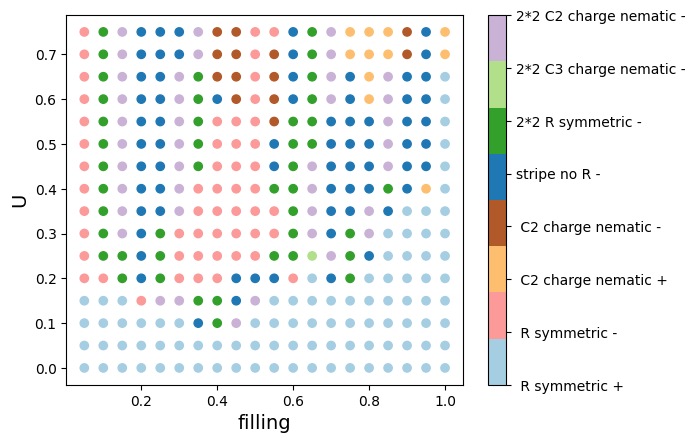

In [47]:
from matplotlib.colors import ListedColormap

paired = plt.get_cmap("Paired").colors
corlor_index = [0,4,6,11,1,3,2,8]
color_list = [paired[i] for i in corlor_index]

cmap = ListedColormap(color_list)
plt.scatter(filling_mesh/8, u_mesh, c=filtered_phase_diagram_updated, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index_updated))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index_updated)))
cbar.set_ticklabels(unique_phase_name_updated)

In [48]:
TB_index=np.where(filtered_phase_diagram>4)
simplified_phase_diagram = filtered_phase_diagram.copy()
simplified_phase_diagram[TB_index] = 5

simplified_phase_list = unique_phase_name[:5]+['TSB']


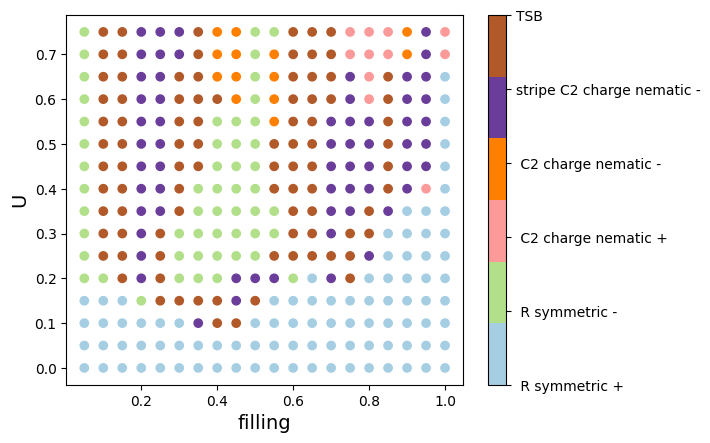

In [49]:
cmap = plt.get_cmap("Paired", len(simplified_phase_list))
plt.scatter(filling_mesh/8, u_mesh, c=simplified_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(simplified_phase_list))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(simplified_phase_list)))
cbar.set_ticklabels(simplified_phase_list)

In [50]:
from matplotlib.colors import ListedColormap

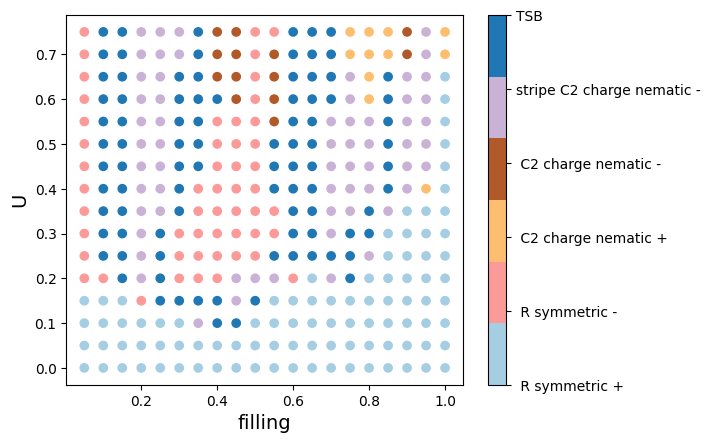

In [51]:
paired = plt.get_cmap("Paired").colors
corlor_index = [0,4,6,11,8,1]
color_list = [paired[i] for i in corlor_index]

cmap = ListedColormap(color_list)
plt.scatter(filling_mesh/8, u_mesh, c=simplified_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(simplified_phase_list))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(simplified_phase_list)))
cbar.set_ticklabels(simplified_phase_list)




# a better phase diagram

In [52]:
nematic_measure = np.zeros((filling_mesh.shape), np.float64)
ts_check = np.zeros((filling_mesh.shape), np.int32)
f_phase = np.zeros((filling_mesh.shape), np.int32)
f_measure = np.zeros((filling_mesh.shape), np.float64)
f_max_measure = np.zeros((filling_mesh.shape), np.float64)

threshold = 1E-2
for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        d_ij = sorted_density[i,j,0]
        ts_diff_arr = translation_check_d(d_ij, translation_a1, translation_a2, translation_a3)
        if np.all(ts_diff_arr<threshold):
            ts_check[i,j] = 0
        elif np.all(ts_diff_arr>threshold):
            ts_check[i,j] = 2
        else:
            ts_check[i,j] = 1
        # if ts_check[i,j]==0:
        # d_ij = d_ij[:,:3]
        #     c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_ij, c_6_uc, c_3_uc, c_2_uc)
        # else:
        c6_diff_o, c3_diff_o, c2_diff_o, magnetism_arr = rot_symm_m_check_d(d_ij, c_6_2uc, c_3_2uc, c_2_2uc)
        c6_diff_x, c3_diff_x, c2_diff_x, _ = rot_symm_m_check_d(d_ij, c_6_2uc_x, c_3_2uc_x, c_2_2uc_x)
        c6_diff_y, c3_diff_y, c2_diff_y, _ = rot_symm_m_check_d(d_ij, c_6_2uc_y, c_3_2uc_y, c_2_2uc_y)    
        c6_diff_gamma, c3_diff_gamma, c2_diff_gamma, _ = rot_symm_m_check_d(d_ij, c_6_2uc_gamma, c_3_2uc_gamma, c_2_2uc_gamma)
        c6_diff = np.min(np.abs(np.array([c6_diff_o, c6_diff_x, c6_diff_y, c6_diff_gamma])))
        nematic_measure[i,j] = c6_diff
        if np.max(np.abs(magnetism_arr)) > threshold:
            if np.all(magnetism_arr > threshold) or np.all(magnetism_arr < -threshold):
                f_phase[i,j] = 1
            else:
                f_phase[i,j] = 2
        else:
            f_phase[i,j] = 0
        f_measure[i,j] = np.mean(np.abs(magnetism_arr))
        f_max_measure[i,j] = np.max(np.abs(magnetism_arr))

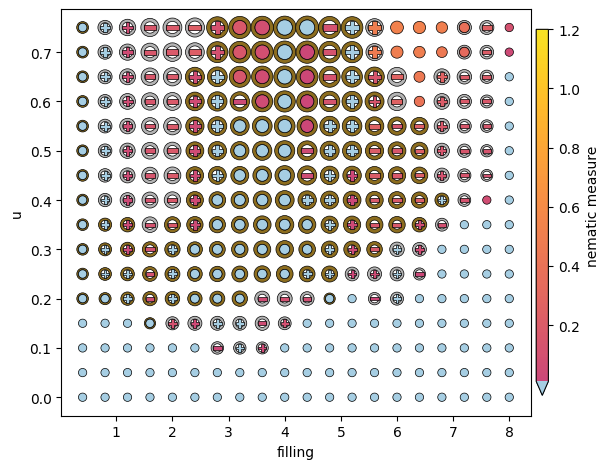

In [53]:
from functions_parameters.phase_plot import PlotConfig, plot_phase_map

CFG = PlotConfig()
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    filling_mesh, u_mesh,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("filling")
ax.set_ylabel("u")
plt.tight_layout(); plt.show()